In [1]:
from src.data.data_management import DataManagement
from src.data.data_transformation import DataTransformation
from src.NN_model.NeuralNetworkModel import NeuralNetworkModel
from src.NN_model.basic_metrics import basic_metrics
from src.vis.visualize import Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Multi-class classification with the usage of Neural Network
This is the last notebook in this project. In this paper I will present the last functionality that I added to the NeuralNetworkModel - it is multiclass classification.

**Earlier, the model has specific limitation:**
- could only work for binary tasks - 0 or 1, *yes* or *no*
- shape of y was  (1, num_examples)
- model was using sigmoid activation function in last layer, because sigmoid function for any given parameter, will always outputs values between 0 and 1.

**Now for the multiclass classification:**
- model can work for any number of classes, but as an input, we have to provide Y as One Hot Encoded Matrix 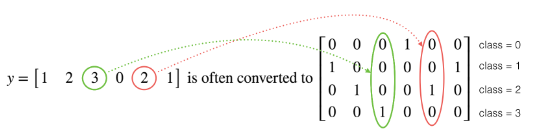
- shape of y is now (num_of_classes, num_examples)
- model is using softmax activation function in the last layer. It was pretty hard for me to come up with derivative formula and vectorization form, so I am going to explaing this now

## Softmax
### Softmax activation function in forward propagation
The formula for softmax is as follows:
$$softmax(z_i) = \frac{e^{z_i}}{ \sum_{i=0}^{C - 1} e^{z_i}} $$

Now, let's put it in the matrix. Matrix for 4 classes and one training example matrics looks like follows:
$$\begin{bmatrix} \frac{e^{z_0}}{ \sum_{c=0}^{C - 1} e^{z_i}}   \\ \frac{e^{z_1}}{ \sum_{c=0}^{C - 1} e^{z_i}}  \\ \frac{e^{z_2}}{ \sum_{c=0}^{C - 1} e^{z_i}}  \end{bmatrix} = \begin{bmatrix} softmax(z_0) \\ softmax(z_1) \\ softmax(z_2) \end{bmatrix}$$
Sum of this vector (matrix) equals to 1. Value for each row (cell) is probability value.
### Softmax derivative in backward propagation
So, we have to compute *dZ* with respect to softmax activation function. But overall derivative  in the in this case, takes also derivative of cost function with respect fo softmax function.

Cost function:
$$ L(\hat{y}, y) = L(a, y) = -\sum_{c=0}^{C-1} y_c  log(a_c)$$

Derivative of cost function with respect to *z*:
$$ \frac{\partial L}{\partial z_j} = -\sum_{c=0}^{C-1} y_c \frac{\partial} {\partial z_j} log(a_c)
= -\sum_{c=0}^{C-1} y_c \frac{\partial log(a_c)} {\partial a_c} \frac{\partial a_c}{\partial z_j}
= -\sum_{c=0}^{C-1} \frac{y_c}{a_c} \frac{\partial a_c}{\partial z_j} = $$
$$ = -\frac{y_c}{a_c}(\frac{\partial a_j}{\partial z_j} + \sum_{c=0, c\neq{j}}^{C-1}\frac{\partial a_j}{\partial z_j})$$
The fraction below is derivative of cost function with respect fo softmax function:
$$ -\frac{y_c}{a_c}$$
And the derivative of softmax function with respect to *z* is as follows:
$$\frac{\partial a_j}{\partial z_j} + \sum_{i=0, c\neq{j}}^{C-1}\frac{\partial a_j}{\partial z_j} $$
I split summation into 2 fraction because of different value of derivative when i = j and when it is not.
- when $i=j$
$$\frac{\partial a_j}{\partial z_j} = \frac{\partial softmax(z_j)}{\partial z_j} = \frac{\partial }{\partial  z_j} \frac{e^{z_j}}{ \sum_{i=0}^{C - 1} e^{z_i}} 
=\frac{\sum_{i=0}^{C - 1} e^{z_i} \frac{\partial}{\partial z_j} e^{z_j} - e^{z_j} \frac{\partial}{\partial z_j}\sum_{i=0}^{C - 1} e^{z_i}} {({\sum_{i=0}^{C - 1} e^{z_i}})^2} = $$

$$= \frac{(\sum_{i=0}^{C - 1} e^{z_i}) e^{z_j} - e^{z_j} e^{z_i}} {({\sum_{i=0}^{C - 1} e^{z_i}})^2}
= \frac{e^{z_j}(\sum_{i=0}^{C - 1} e^{z_i} - e^{z_i})} {({\sum_{i=0}^{C - 1} e^{z_i}})^2}
= \frac{e^{z_j}} {({\sum_{i=0}^{C - 1} e^{z_i}})} \frac{\sum_{i=0}^{C - 1} e^{z_i} - e^{z_i}} {({\sum_{i=0}^{C - 1} e^{z_i}})}$$
$$= softmax(z_j) (1 - softmax(z_j))$$

- when $i\neq j$

$$\frac{\partial a_i}{\partial z_j} = \frac{\partial softmax(z_i)}{\partial z_j} = \frac{\partial }{\partial  z_j} \frac{e^{z_i}}{ \sum_{i=0}^{C - 1} e^{z_i}} 
=\frac{(\sum_{i=0}^{C - 1} e^{z_i}) \frac{\partial}{\partial z_j} e^{z_i} - e^{z_i} \frac{\partial}{\partial z_j}(\sum_{i=0}^{C - 1} e^{z_i})} {({\sum_{i=0}^{C - 1} e^{z_i}})^2} = $$


$$ = \frac{0 - e^{z_i}  e^{z_j})} {({\sum_{i=0}^{C - 1} e^{z_i}})^2}  
= - \frac{e^{z_i}} {({\sum_{i=0}^{C - 1} e^{z_i}})} \frac{e^{z_j}} {({\sum_{i=0}^{C - 1} e^{z_i}})} = -softmax(z_i)softmax(z_j)$$

**Summary of a softmax derivative:**
$$\frac{\partial softmax(z_i)}{\partial z_j} = 
\begin{cases}
softmax(z_j)* (1 - softmax(z_j)) \ \ \ \ \text{when } i=j\\
-softmax(z_i)*softmax(z_j )\ \ \ \ \text{when } i\neq j
\end{cases}$$
###  Softmax derivative vectorization
So we need following formula for every example:
$$\frac{\partial a_j}{\partial z_j} + \sum_{i=0, c\neq{j}}^{C-1}\frac{\partial a_j}{\partial z_j} $$
In other words:
$$softmax(z_j)* (1 - softmax(z_j)) + \sum_{i=0, c\neq{j}}^{C-1} -softmax(z_i)*softmax(z_j )$$
And now I will show you how to vectorize this expression:
- let's define vector *s*
$$s = \begin{bmatrix} softmax(z_0) \\ softmax(z_1) \\ softmax(z_2) \end{bmatrix}$$
- let's compute dot product of $s*s.T$ this is a result:

$$s*s.T = \begin{bmatrix} softmax(z_0)* softmax(z_0) & softmax(z_0)*softmax(z_1) & softmax(z_0)*softmax(z_2)\\ softmax(z_0)*softmax(z_1) & softmax(z_1)*softmax(z_1) & softmax(z_1)*softmax(z_2) \\ softmax(z_0)*softmax(z_2) & softmax(z_1)*softmax(z_2) & softmax(z_2)*softmax(z_2)\end{bmatrix}$$

- if we calculate following formula $s*np.identity(s.size) - np.dot(s, s.T)$ we are going to get:

$$\begin{bmatrix} softmax(z_0) - softmax(z_0)*softmax(z_0) & -softmax(z_0)*softmax(z_1) & -softmax(z_0)*softmax(z_2)\\ -softmax(z_0)*softmax(z_1) & softmax(z_1) - softmax(z_1)*softmax(z_1) & -softmax(z_1)*softmax(z_2) \\ -softmax(z_0)*softmax(z_2) & -softmax(z_1)*softmax(z_2) & softmax(z_2) - softmax(z_2)*softmax(z_2)\end{bmatrix}$$

let's name this matrix as <strong>$ds$</strong>

- we are almost there. To calcuate backward propagation step, we will pass derivative of cost function with respect to softmax as a parameter. Those values looks as follows:
$$dAL = \begin{bmatrix} \frac{y_0}{softmax(z_0)} \\ \frac{y_1}{softmax(z_1)} \\ \frac{y_2}{softmax(z_2)} \end{bmatrix}$$

- and now, to get expression that we want, we have to compute dot product of $ds*dAL$

<strong>Note</strong>: To make those calculation more readable I am going to write $softmax(z_i)$ as $a(z_i)$

$$np.dot(ds, dAL) =
\begin{bmatrix} 
\frac{y_0}{a(z_0)} [a(z_0) - a(z_0)*a(z_0)] + \frac{y_1}{a(z_1)} [-a(z_0) a(z_1)] + \frac{y_2}{a(z_2)} [-a(z_0) a(z_2)] \\
\frac{y_0}{a(z_0)} [-a(z_0) a(z_1)] + \frac{y_1}{a(z_1)} [a(z_1) - a(z_1)*a(z_1)] + \frac{y_2}{a(z_2)} [-a(z_1) a(z_2)] \\
\frac{y_0}{a(z_0)} [-a(z_0) a(z_2)] + \frac{y_1}{a(z_1)} [-a(z_1) a(z_2)] + \frac{y_2}{a(z_2)} [a(z_2) - a(z_2)*a(z_2)]
\end{bmatrix}$$

And that the expression that is needed to calculate softmax derivative.
###  Softmax derivative vectorization for multiple examples
This guide was only for 1 training example. How to vectorize this across entire trainig set? Let's say we have 3 examples, every each one of them has 2 features. Matrix shape is $(2,3)$
- after computing $s$, unroll examples one by one to a column vector $(2,3)-> (6, 1)$
- add a mask to the expression for $ds = s*np.identity(s.size) - mask*np.dot(s, s.T)$. Dot product of $np.dot(s, s.T)$ has a shape $(6,6)$, so a mask also will have a shape $(6,6)$ since this is element-wise multiplication. Mask looks as follows:
$$mask =
\begin{bmatrix}
1 & 1 &  0 & 0 & 0 & 0 \\
1 & 1 &  0 & 0 & 0 & 0 \\ 
0 & 0 &  1 & 1 & 0 & 0 \\
0 & 0 &  1 & 1 & 0 & 0 \\
0 & 0 &  0 & 0 & 1 & 1 \\
0 & 0 &  0 & 0 & 1 & 1 \\
\end{bmatrix}$$
- unroll values of $dAL$ to a colum vector $(2,3)-> (6, 1)$
- calculate final derivative $dZ = np.dot(ds, dAL)$
- reshape $dZ$ back to required shape $(6, 1)-> (2, 3)$

## Let's take a look a dataset
Let's take a look at the data. This dataset contains 6 different classes of pictures (picture of hand showing numbers from 0 to 5) 

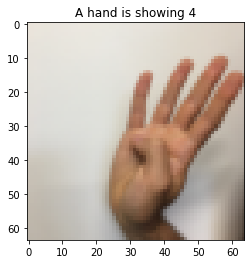

In [2]:
example_data, example_label, _, _ = DataManagement.load_dataset("data/signs/raw/", "train_signs.h5", "test_signs.h5",
                                                                vectorize=False, normalize=False)
r = np.random.choice(len(example_data))
plt.title(f"A hand is showing {example_label[r]}")
plt.imshow(example_data[r])
plt.show()

Originally, the data set stores images in matrices 64x64x3 and labes as an array (no dimension at all). What is more, RGB channels format has a range 0-255.

In [3]:
print(f"Dimensions and resolution of images: {example_data[r].shape}")
print(f"Dimensions of stored labels: {example_label[r].shape}")
print(f"Range of a random example: {np.ptp(example_data[r])}")

Dimensions and resolution of images: (64, 64, 3)
Dimensions of stored labels: ()
Range of a random example: 215


## Preprocessing of dataset
### Vectorization and normalization
In the next step I will vectorize my features - earlier it was stored in 3D array, but now every example will be stored as a column vector. Labels will be stored as vectors as well. What is more, the features will be normalized - in this case all the values will be divided by 255, so new range is between 0 and 1. This operations are provided in DataManagement class during import of a data. So, let's one more time import data, with those options turned on.

In [4]:
train_x, train_y, test_x, test_y = DataManagement.load_dataset("data/signs/raw/", "train_signs.h5", "test_signs.h5",
                                                                vectorize=True, normalize=True)

In [5]:
print(f"Training set shape: {train_x.shape}")
print(f"Training set labels shape: {train_y.shape}")
print(f"Range of a random example: {np.ptp(train_x[r])}")

Training set shape: (12288, 1080)
Training set labels shape: (1, 1080)
Range of a random example: 0.7294117647058824


So now, a variable train_x stores 12288 features (pixels represented as a colum vector) for every each of 1080 examples.
### One hot encoding
As I mentioned earlier, multi-class classification requires Y labels to be One Hot Encoded. This can be achived with the usage of DataTransformation.

In [6]:
train_y_hot = DataTransformation.one_hot_matrix(train_y)
test_y_hot = DataTransformation.one_hot_matrix(test_y)

Let's compare original Y to its representation as One Hot Encoded Matrix

In [7]:
print(f"Original Y: {train_y[:, :5]}\n", f"One hot encoded Y:\n{train_y_hot[:, : 5]}", sep="\n")

Original Y: [[5 0 2 5 2]]

One hot encoded Y:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]]


## Training multiple models
In this example model is pretty complicated and learns slow - it has to deal with 1080 examples and 12288 features. I have tried some values earlier and found those that provide quite good results. In this notebook I will not do GridSearch and analyze results - something like this was done in notebook #1, so you can take a look how finding a good set of hyper-parameters should be done. In this case I will just simply provie those hyper-parameters values that I found.

First of all, let's determine *hidden layers dimensions*:

In [8]:
hidden_layers = [32, 16]

Let's also create DataFrame that will store costs for every trained model:

In [9]:
indexes = [['multiclass classification']*3, ["no regularization", "dropout", "l2"]]
models_costs = pd.DataFrame(columns=['cost'], index=indexes)

### Without regularization

In [10]:
np.random.seed(3)
model = NeuralNetworkModel(hidden_layers, num_epochs=500, optimizer="adam", mini_batch_size=64,
                           learning_rate=0.001, decay=True, decay_rate=2, time_interval=80,
                           print_cost=50, save_costs=10)
model.fit(train_x, train_y_hot)

Cost after iteration 0: 3.382118205259284
Cost after iteration 50: 0.836122581129466
Cost after iteration 100: 0.5014806117090994
Cost after iteration 150: 0.37922001288823004
Cost after iteration 200: 0.2860514891477746
Cost after iteration 250: 0.23780309815130934
Cost after iteration 300: 0.211749781092755
Cost after iteration 350: 0.1807700773924399
Cost after iteration 400: 0.1647272247267143
Cost after iteration 450: 0.14069025233305704
Cost after iteration 499: 0.12338880959683331


Lets do prediction on a training set and test set, calculate metrics and save them. Costs values registered during training will be saved as well. We are going to come back to this results in the summary.

**Note:** Method *predic* from NeuralNetworkModel class return predictions in One Hot Encoding format, we have to change it back to numerical values for each row. For that I am going use a method *one_hot_to_num* from DataTransformation class.

In [11]:
preds = model.predict(train_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model.predict_proba(train_x)
model_metrics = basic_metrics(train_y, preds, proba, average="macro")
metrics_train = pd.DataFrame(columns=list(model_metrics.keys()))
metrics_train.loc["Training, no regularization"] = model_metrics

preds = model.predict(test_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model.predict_proba(test_x)
model_metrics = basic_metrics(test_y, preds, proba, average="macro")
metrics_test = pd.DataFrame(columns=list(model_metrics.keys()))
metrics_test.loc["Test, no regularization"] = model_metrics

In [12]:
models_costs.loc[("multiclass classification", "no regularization"), "cost"] = model.get_costs()

### With dropout regularization
Dropout regularization should not be used with *adam*, this is because *adam* "remembers" state of past gradients and uses them during weights updating. The point of dropout is to randomly drop some activation nodes, it causes to set gradient of dropped activation node to 0. There is no point for this value of dropped gradient to have an impact for new calculated weights values.

In [13]:
np.random.seed(3)
model_dropout = NeuralNetworkModel(hidden_layers, num_epochs=1000, optimizer="gd", mini_batch_size=64,
                                   dropout_keep_prob=0.9, learning_rate=0.001,
                                   decay=True, decay_rate=1, time_interval=150, print_cost=100, save_costs=10)
model_dropout.fit(train_x, train_y_hot)

Cost after iteration 0: 1.818839766541559
Cost after iteration 100: 1.3962800155390478
Cost after iteration 200: 1.1081808984559287
Cost after iteration 300: 0.9249814843139633
Cost after iteration 400: 0.8650697588024403
Cost after iteration 500: 0.7856452701339225
Cost after iteration 600: 0.7555933617251476
Cost after iteration 700: 0.7141412734776744
Cost after iteration 800: 0.6920967213734095
Cost after iteration 900: 0.6767124881234026
Cost after iteration 999: 0.6567116076991752


In [14]:
preds = model_dropout.predict(train_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model_dropout.predict_proba(train_x)
metrics_train.loc["Training, dropout"] = basic_metrics(train_y, preds, proba, average="macro")

preds = model_dropout.predict(test_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model_dropout.predict_proba(test_x)
metrics_test.loc["Test, dropout"] = basic_metrics(test_y, preds, proba, average="macro")

In [16]:
models_costs.loc[("multiclass classification", "dropout"), "cost"] = model_dropout.get_costs()

### With L2 regularization


In [17]:
np.random.seed(3)
model_l2 = NeuralNetworkModel(hidden_layers, num_epochs=500, optimizer="adam", mini_batch_size=64, l2_lambda=0.7,
                              learning_rate=0.001,decay=True, decay_rate=2, time_interval=80, print_cost=50, save_costs=10)
model_l2.fit(train_x, train_y_hot)

Cost after iteration 0: 3.776829605145856
Cost after iteration 50: 1.0825980664939434
Cost after iteration 100: 0.7514538283174061
Cost after iteration 150: 0.6942926568748307
Cost after iteration 200: 0.6355753600631424
Cost after iteration 250: 0.5977905922052414
Cost after iteration 300: 0.5527266224076951
Cost after iteration 350: 0.5379184494205674
Cost after iteration 400: 0.5089531494794173
Cost after iteration 450: 0.4891747409909203
Cost after iteration 499: 0.46703304708017074


In [18]:
preds = model_l2.predict(train_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model_l2.predict_proba(train_x)
metrics_train.loc["Training, l2"] = basic_metrics(train_y, preds, proba, average="macro")

preds = model_l2.predict(test_x)
preds = DataTransformation.one_hot_to_num(preds)
proba = model_l2.predict_proba(test_x)
metrics_test.loc["Test, l2"] = basic_metrics(test_y, preds, proba, average="macro")

In [19]:
models_costs.loc[("multiclass classification", "l2"), "cost"] = model_l2.get_costs()

##  Analysis of a performance
### Gradient visualization for different models

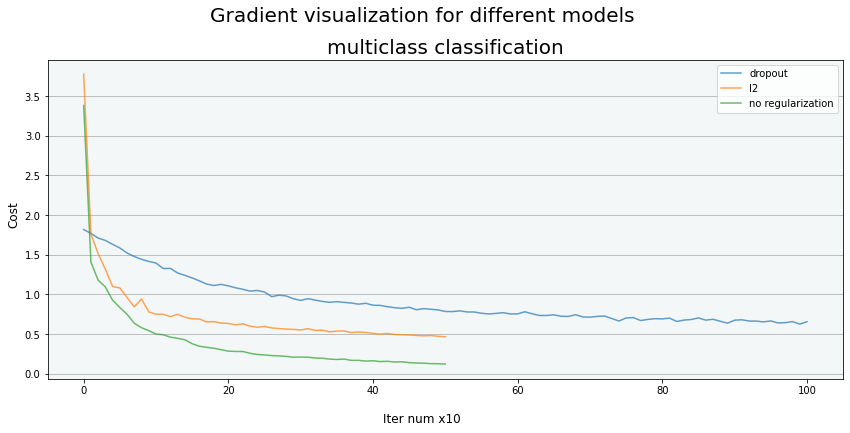

In [20]:
Visualization.gradient_visualization(models_costs.cost, 10, "Gradient visualization for different models")

Model with dropout needed twice many epochs as model without regularization or with l2 regularization to provide good results. Cost function for every model decrases with the epochs passed.
### Metrics - accuracy, f1, precision, recall, ROC
In this section I will present metrics for 3 different model. First of all, metrics on a training set.

In [21]:
metrics_train

,accuracy,f1,precision,recall,AUC
"Training, no regularization",0.980556,0.980570,0.980912,0.980556,0.998271
"Training, dropout",0.912037,0.911094,0.912921,0.912037,0.990954
"Training, l2",0.950926,0.951223,0.952745,0.950926,0.996362


Metrics of all models, have all the scores above 90%. It means that those models learned data pretty well, but let's see how they perform on a data they've never seen before.

In [22]:
metrics_test

,accuracy,f1,precision,recall,AUC
"Test, no regularization",0.808333,0.804552,0.808034,0.808333,0.971583
"Test, dropout",0.816667,0.817240,0.827085,0.816667,0.969250
"Test, l2",0.783333,0.784227,0.789520,0.783333,0.967583


**Summary:**

The best f1 score on a test set is a little above 80%. Taking into consideration a fact, that human can always correctly classify a quantity of fingers on an image, the results are not that good.

Due to that fact, the question arises. **What can be done to incraese model's performnce?**
- we can try different hyper-parameters for models, for example create grid search and learn models all night
- adding more data will prevent model from overfitting - the more varity in examples, the better prediction on unknown data

**One thing to remember** - we should split data into 3 sets: training, cross-validation and test:
- train data on a training set (have a nice performance during training)
- evaluate model on a cross-validation set - choose set of hyper-parameters with the respect on data that wasn't seen by a model
- run a true test on a test set

### Prediction on a random example for the best model:

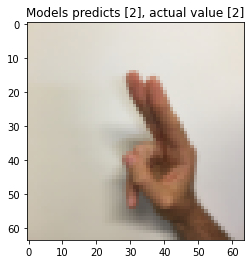

In [24]:
rand_num = np.random.choice(test_x.shape[1])
random_sample = test_x[:, rand_num:rand_num+1]
prediction = model_dropout.predict(random_sample)
plt.title(f"Models predicts {np.argmax(prediction, axis=0)}, actual value {test_y[:, rand_num]}")
plt.imshow(random_sample.reshape(64, 64, 3))
plt.show()